In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
# import pingouin as pg
# import os
# import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [4]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [2]:
loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\decoder_accuracy_by_session.parquet"
new_results_session_pd = pd.read_parquet(loadpath)

In [50]:
sel_bin_center=-0.25
structure_excl_list=['root','lot','ECT2/3','ECT5','ECT6a','ECT6b','CTXsp','MB','OLF','TH','SCsg','SCzo','SCop','SCig','SCiw','SCdg','SCdw','STR','PAL','VL','V3','SEZ','out of brain']
new_results_session_filtered=new_results_session_pd.query('bin_center==@sel_bin_center and session_id in @dr_session_list and structure not in @structure_excl_list')

In [51]:
unique_structures=new_results_session_filtered['structure'].unique()

unique_structures

array(['ACAd', 'ACAv', 'ACB', 'AD', 'AId', 'AIp', 'AIv', 'AMd', 'AMv',
       'AON', 'APN', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'AV', 'BST', 'CA1',
       'CA2', 'CA3', 'CEAm', 'CL', 'CLA', 'CP', 'CS', 'DG', 'DP', 'DTN',
       'ECT', 'ENTl', 'ENTm', 'EPd', 'Eth', 'FF', 'FRP', 'GPe', 'GPi',
       'GRN', 'GU', 'IAD', 'ICd', 'ICe', 'IG', 'ILA', 'LA', 'LD', 'LGd',
       'LGv', 'LH', 'LHA', 'LP', 'LSc', 'LSr', 'LSv', 'MD', 'MGd', 'MGm',
       'MGv', 'MH', 'MOB', 'MOp', 'MOs', 'MPT', 'MRN', 'MS', 'NB', 'NOT',
       'OP', 'ORBl', 'ORBm', 'ORBvl', 'OT', 'PAG', 'PAR', 'PCN', 'PERI',
       'PF', 'PIR', 'PL', 'PO', 'POL', 'POST', 'PP', 'PPT', 'PR', 'PRE',
       'PSTN', 'PoT', 'ProS', 'RN', 'RSPagl', 'RSPd', 'RSPv', 'RT', 'SAG',
       'SCm', 'SCs', 'SF', 'SGN', 'SH', 'SMT', 'SNr', 'SSp', 'SSs', 'SUB',
       'TEa', 'TRS', 'TTd', 'VAL', 'VISC', 'VISa', 'VISal', 'VISam',
       'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl', 'VM',
       'VPL', 'VPLpc', 'VPM', 'VPMpc', 'VTA', 'ZI'

In [181]:
###note: not exhaustive; update if new structures are added
simplfied_structure_grouping = {
    'Frontal':['FRP','ACAd','ACAv','ORBl','ORBvl','ORBm','PL','ILA','AId','MOs'],
    # 'Somatomotor':['MOs','MOp','SSp','SSs'],
    # 'Lateral':['AId','AIp','AIv','GU','VISC','TEa','PERI','ECT'],
    'Somatomotor':['MOp','SSp','SSs'],
    'Lateral':['AIp','AIv','GU','VISC','TEa','PERI','ECT'],
    
    'Visual':['VISp', 'VISl', 'VISal', 'VISli', 'VISpl', 'VISpor', 'VISrl'],
    'Medial':['VISa', 'VISam', 'VISpm', 'RSPagl', 'RSPd', 'RSPv',],
    'Auditory':['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'CTXsp':['CLA','EPd','EPv','LA','BLA','BMA','PA'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG','IG','ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','TTd','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','VPMpc','MGd','MGv','MGm','LGd','PP','PoT'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'Striatum':['CP','ACB','OT','LSc','LSr','LSv','CEAm','SF','SH'],
    'Pallidum':['GPe','GPi','BST','MS','TRS'],
    'Hypothalamus':['LHA','ZI','FF','PSTN'],
    'Midbrain - sensory':['SCs','ICd','ICe','SAG','NB',],
    'Midbrain - motor':['SCm','MRN','RN','APN','MPT','NOT','OP','PAG','PPT','VTA','SNr','SNc','PPN'],
    'Hindbrain':['CS','DTN',],
    'Medulla':['GRN']
}

In [76]:
new_results_session_filtered.columns

Index(['total_n_units', 'structure', 'bin_size', 'unit_subsample_size',
       'cross_modality_dprime_vis_blocks', 'n_passing_blocks',
       'time_aligned_to', 'cross_modality_dprime_aud_blocks', 'session_id',
       'bin_center', 'mean_true', 'median_null', 'balanced_accuracy_test',
       'shift_idx', 'mean_diff'],
      dtype='object')

In [135]:
# new_results_session_filtered.query('structure=="SNc"')

In [194]:
## loop through the above dictionary, and use it to build a new dataframe in the desired order

structure_wise_dict={
    'structure':[],
    'structure_group':[],
    'decoding_accuracy_list':[],
    'decoding_accuracy_mean':[],
    'decoding_accuracy_sem':[],
    'n_sessions':[],
}

track_structures_added=[]

for structure_group, structure_list in simplfied_structure_grouping.items():
    for structure in structure_list:
        if structure in unique_structures:
            structure_wise_dict['structure'].append(structure)
            structure_wise_dict['structure_group'].append(structure_group)
            decoding_accuracy_list=new_results_session_filtered.query('structure==@structure')['mean_diff'].to_list()
            structure_wise_dict['decoding_accuracy_list'].append(decoding_accuracy_list)
            structure_wise_dict['decoding_accuracy_mean'].append(np.mean(decoding_accuracy_list))
            structure_wise_dict['decoding_accuracy_sem'].append(stats.sem(decoding_accuracy_list))
            structure_wise_dict['n_sessions'].append(len(decoding_accuracy_list))
            track_structures_added.append(structure)

structure_wise_df=pd.DataFrame(structure_wise_dict)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_8592\510326635.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  structure_wise_dict['decoding_accuracy_sem'].append(stats.sem(decoding_accuracy_list))


In [177]:
#check if all structures were added
set(unique_structures).difference(set(track_structures_added))

set()

<Axes: xlabel='structure'>

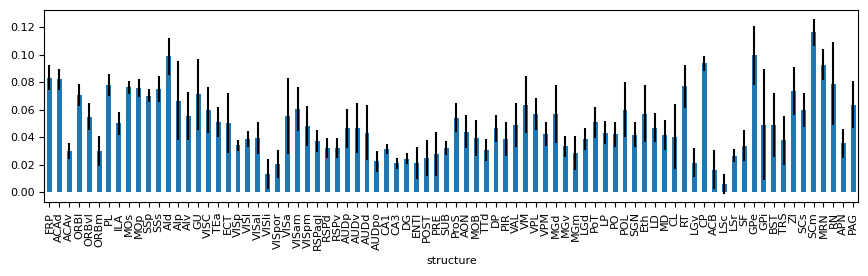

In [178]:
fig,ax=plt.subplots(1,1,figsize=(10.5,2.5))

structure_wise_df.query('n_sessions>=4').plot.bar(x='structure', y='decoding_accuracy_mean', yerr='decoding_accuracy_sem', ax=ax, legend=False)


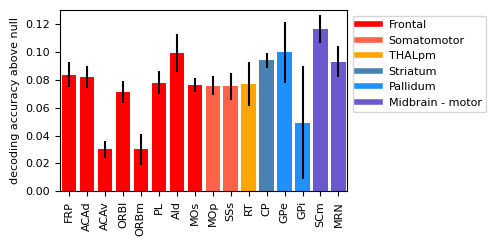

In [199]:
# make a bar plot of mean decoding accuracy across structures. color bars by their structure group. add a label underneath the axis labels indicating the structure group

min_n_sessions=4
flag_limit_n_structures=False
n_limited_structures=20
use_custom_list=True

#find the top 20 structures by mean decoding accuracy
if flag_limit_n_structures:
    sel_structures=structure_wise_df.query('n_sessions>=@min_n_sessions').sort_values(by='decoding_accuracy_mean', ascending=False).head(n_limited_structures)['structure'].to_list()
    plot_structure_list = []
    for structure in structure_wise_df['structure']:
        if structure in sel_structures:
            plot_structure_list.append(structure)
elif use_custom_list:
    # sel_structures=['FRP','ACAd','ACAv','ORBl','ORBm','PL','ILA',
    #                 'MOs','MOp','SSp','SSs',
    #                 'AId','AIv','TEa',
    #                 'VISp', 'VISl', 'VISli', 'VISpor',
    #                 'VISam', 'VISpm', 'RSPagl', 'RSPd', 'RSPv',
    #                 'AUDp', 'AUDv', 'AUDd', 'AUDpo',
    #                 'CA1','DG',
    #                 'VAL','VPM','MGd','LGd',
    #                 'LP','PO','LD','MD','RT',
    #                 'CP','ACB','GPe',
    #                 'SCs','SCm','MRN','PAG'
    #                 ]
    sel_structures=[
        'FRP', 'ACAd', 'ACAv', 'ORBl', 'ORBm', 'PL', 'AId', 'MOs',
        'MOp', 'SSs',
        'RT',
        'CP', 'GPe', 'GPi',
        'SCm', 'MRN',
    ]
    
    plot_structure_list = [structure for structure in sel_structures if structure in structure_wise_df.query('n_sessions>=@min_n_sessions')['structure'].to_list()]
else:
    plot_structure_list=structure_wise_df.query('n_sessions>=@min_n_sessions')['structure'].to_list()

if flag_limit_n_structures:
    color_list=['red','tomato','orange','slateblue','steelblue','dodgerblue','mediumturquoise','limegreen',
                'forestgreen','darkgreen','orchid','mediumvioletred','crimson','maroon','saddlebrown']
elif use_custom_list:
    color_list=['red','tomato','orange','steelblue','dodgerblue','slateblue','mediumturquoise','limegreen',
                'forestgreen','skyblue','thistle','orchid','mediumvioletred','crimson','maroon','saddlebrown']
else:
    color_list=['red','tomato','orange','steelblue','dodgerblue','slateblue','mediumturquoise','powderblue','limegreen',
                'forestgreen','skyblue','thistle','lightpink','orchid','mediumvioletred','crimson','maroon','saddlebrown']
color_idx=0
use_color=''
groups_color_dict={}

if flag_limit_n_structures:
    if n_limited_structures <= 20:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(7, 3))
else:
    # fig,ax=plt.subplots(1,1,figsize=(9.5,3))
    fig,ax=plt.subplots(1,1,figsize=(5,2.5))

for i, structure in enumerate(plot_structure_list):
    structure_group = structure_wise_df.query('structure==@structure')['structure_group'].values[0]
    if structure_group not in groups_color_dict:
        groups_color_dict[structure_group] = color_list[color_idx]
        color_idx += 1
    use_color = groups_color_dict[structure_group]

    ax.bar(i, structure_wise_df.query('structure==@structure')['decoding_accuracy_mean'].values[0],
           yerr=structure_wise_df.query('structure==@structure')['decoding_accuracy_sem'].values[0],
           color=use_color,
           label=structure_group)

# ax.set_ylim([0.5,0.78])
ax.set_ylim([0,0.13])
ax.set_xlim([-0.5, len(plot_structure_list)-0.5])
ax.set_ylabel('decoding accuracy above null')
ax.set_xticks(range(len(plot_structure_list)))
ax.set_xticklabels(plot_structure_list, rotation=90, fontsize=8)

#make separate legend for structure groups
legend_handles = []
for group, color in groups_color_dict.items():
    legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label=group))
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

fig.tight_layout()

In [200]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\decoding_acc_above_null_across_structures_shawns_picks.pdf'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='pdf', pad_inches=0.1)

In [143]:
sel_structures

['SCm',
 'GPe',
 'AId',
 'CP',
 'MRN',
 'FRP',
 'ACAd',
 'RN',
 'PL',
 'RT',
 'MOs',
 'MOp',
 'SSs',
 'ZI',
 'GU',
 'ORBl',
 'SSp',
 'AIp',
 'PAG',
 'VM']

In [ ]:
#save figure
# fig.savefig(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\decoding_accuracy_across_structures_custom_order_linear_shift.pdf", bbox_inches='tight', dpi=300)

In [101]:
structure_wise_df.query('n_sessions>=4')['structure_group'].unique().shape

(15,)

In [31]:
structure_wise_df.query('structure=="EPd"')

,structure,structure_group,decoding_accuracy_list,decoding_accuracy_mean,decoding_accuracy_sem,n_sessions
37,EPd,CTXsp,"[0.8675024665257225, 0.6906793522267206, 0.496...",0.685016,0.107031,3


In [201]:
new_results_session_pd.query('structure=="GU"')['session_id'].unique()

array(['741148_2024-10-16', '668755_2023-08-30', '708016_2024-04-29',
       '742903_2024-10-22', '686176_2023-12-07', '742903_2024-10-21'],
      dtype=object)